# Exercise 2 - Logistic Regression

Initial coding environment, import self defined optimizers and models

In [1]:
import os as _os, sys as _sys
_curr_dir = _sys.path[0]
_base_dir = _os.path.dirname(_os.path.dirname(_curr_dir))
_sys.path.insert(0, _base_dir)
import optimizer as opt, models as md
print('Successfully import <optimizer> and <models>')
del _curr_dir, _base_dir, _os, _sys

Successfully import <optimizer> and <models>


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print('Successfully import <matplotlib>, <numpy> and <pandas>')

Successfully import <matplotlib>, <numpy> and <pandas>


In [3]:
def add_column_1_to_vector(*input_vectors):
    assert len(input_vectors) > 0
    assert len(set(map(len, input_vectors))) == 1
    vector_list = list(input_vectors)
    vector_list.insert(0, np.ones(len(input_vectors[0])))
    return np.array(vector_list).T


def normalize(x):
    return (x - x.mean()) / x.std()


print('Two utility functions are defined: <add_column_1_to_vector> and <normalize>')

Two utility functions are defined: <add_column_1_to_vector> and <normalize>


## Q1. Logistic regression

Original data plotting:

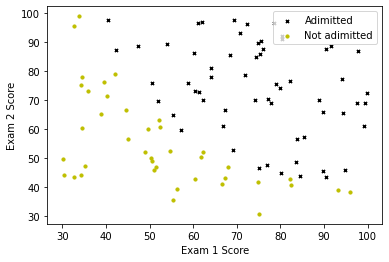

In [4]:
data = np.loadtxt('ex2data1.txt', delimiter=',')
x1, x2, y = data[:, 0], data[:, 1], data[:, 2]

admitted = np.argwhere(y == 1).T[0]
not_admitted = np.argwhere(y == 0).T[0]

plt.scatter(x1[admitted], x2[admitted], s=10, c='k', marker='x', label='Adimitted')
plt.scatter(x1[not_admitted], x2[not_admitted], s=10, c='y', marker='o', label='Not adimitted')
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.legend(loc='upper right')
plt.show()

Logistic regression using wrapped scipy conjugate gradient optimizer:

C:\Users\Tongyan Xu\Desktop\code\python\ml_study\models\regression.py:174: RuntimeWarning: divide by zero encountered in log
  part_2 = (1 - self.y) @ _np.log(1 - self.hypothesis(self.x, theta))
C:\Users\Tongyan Xu\Desktop\code\python\ml_study\models\regression.py:174: RuntimeWarning: invalid value encountered in matmul
  part_2 = (1 - self.y) @ _np.log(1 - self.hypothesis(self.x, theta))


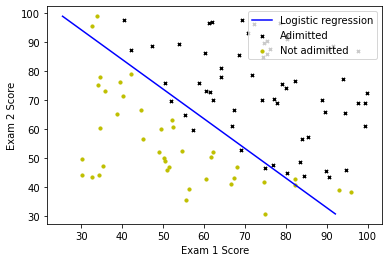

[-25.14157165   0.20607372   0.20131161]


In [5]:
lr_model = md.LogisticRegression(add_column_1_to_vector(x1, x2), y)

cgs = opt.ConjugateGradientScipy(
    max_iter=1E5,
    g_tol=1E-5,
    g_norm=2,
)

lr_model.train(cgs)

# sigmoid(z) = 1 / (1 + exp(- z)) = 1 / 2
# -> exp(- z) = exp(- x @ theta) = 1
# -> x @ theta = theta[0] + theta[1] * x1 + theta[2] * x2 = 0
# -> x2 = [- theta[0] / theta[2], - theta[1] / theta[2]] @ [1, x1]
# -> x2 = [theta[0], theta[1]] @ [1, x] * (- 1 / theta[2])

theta = lr_model.result.theta
cvt_1to2 = - np.array([theta[0], theta[1]]) / theta[2]
cvt_2to1 = - np.array([theta[0], theta[2]]) / theta[1]

x1_temp = add_column_1_to_vector([min(x2), max(x2)]) @ cvt_2to1
x1_line = [max(min(x1), x1_temp[0]), min(max(x1), x1_temp[1])]
x2_line = add_column_1_to_vector(x1_line) @ cvt_1to2

plt.scatter(x1[admitted], x2[admitted], s=10, c='k', marker='x', label='Adimitted')
plt.scatter(x1[not_admitted], x2[not_admitted], s=10, c='y', marker='o', label='Not adimitted')
plt.plot(x1_line, x2_line, c='blue', label='Logistic regression')
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.legend(loc='upper right')
plt.show()

del x1_line, x2_line, x1_temp, cgs, cvt_1to2, cvt_2to1, theta

print(lr_model.result.theta)

In [6]:
# Before step into Q2, clean up Q1 local variables
del data, x1, x2, y, lr_model, admitted, not_admitted
print('Successfully clean up Q1 memories')

Successfully clean up Q1 memories


## Q2. Regularized logistic regression

Original data plotting:

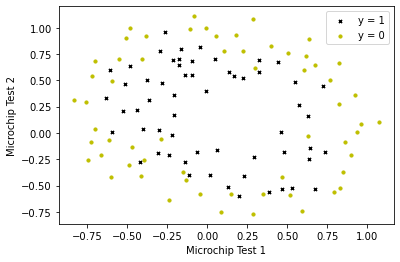

In [7]:
data = np.loadtxt('ex2data2.txt', delimiter=',')
x1, x2, y = data[:, 0], data[:, 1], data[:, 2]

index_1 = np.argwhere(y == 1).T[0]
index_0 = np.argwhere(y == 0).T[0]

plt.scatter(x1[index_1], x2[index_1], s=10, c='k', marker='x', label='y = 1')
plt.scatter(x1[index_0], x2[index_0], s=10, c='y', marker='o', label='y = 0')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc='upper right')
plt.show()

Preparing utility functions:

In [8]:
def polynomial_extension(x1, x2, degree=6):
    args = [np.power(x1, j) * np.power(x2, i - j) 
            for i in range(1, degree + 1) for j in range(i + 1)]
    return add_column_1_to_vector(*args)


def show_decision_boundary(theta, degree=6, density=2001, threshold=5E-3):
    # sigmoid(z) = 1 / (1 + exp(- z)) = 1 / 2
    # -> exp(- z) = exp(- x @ theta) = 1
    # -> x @ theta = 0
    length = density ** 2
    axis = np.linspace(-1, 1.5, density)
    x1_grid, x2_grid = np.meshgrid(axis, axis)
    x1_grid = x1_grid.reshape(1, length)[0]
    x2_grid = x2_grid.reshape(1, length)[0]
    x_grid = polynomial_extension(x1_grid, x2_grid, degree)
    index = np.argwhere(np.abs(x_grid @ theta) < threshold).T[0]
    return x1_grid[index], x2_grid[index]


print('Two utility functions are defined: <polynomial_extension> and <show_decision_boundary>')

Two utility functions are defined: <polynomial_extension> and <show_decision_boundary>


Setup parameters:

In [9]:
degree = 6
density = 2001
threshold = 5E-3

In [10]:
x = polynomial_extension(x1, x2, degree)

rlr_model = md.RegularizedLogisticRegression(x, y, lambda_value=1)

cgs = opt.ConjugateGradientScipy(
    max_iter=1E5,
    g_tol=1E-5,
    g_norm=2,
)

rlr_model.train(cgs)

Show decision boundary:

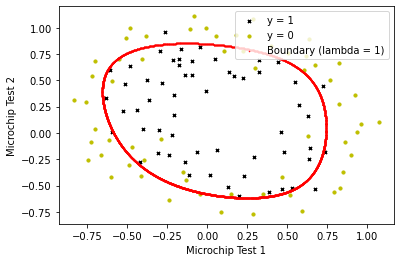

In [11]:
x1_grid, x2_grid = show_decision_boundary(rlr_model.result.theta, degree, density, threshold)

plt.scatter(x1[index_1], x2[index_1], s=10, c='k', marker='x', label='y = 1')
plt.scatter(x1[index_0], x2[index_0], s=10, c='y', marker='o', label='y = 0')
plt.scatter(x1_grid, x2_grid, s=1, c='r', marker='.', label=f'Boundary (lambda = 1)')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc='upper right')
plt.show()

del rlr_model, x1_grid, x2_grid

Change value of lambda:

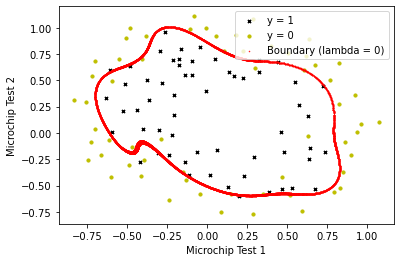

In [12]:
threshold = 5E-2
rlr_model = md.RegularizedLogisticRegression(x, y, lambda_value=0)
rlr_model.train(cgs)
x1_grid, x2_grid = show_decision_boundary(rlr_model.result.theta, degree, density, threshold)

plt.scatter(x1[index_1], x2[index_1], s=10, c='k', marker='x', label='y = 1')
plt.scatter(x1[index_0], x2[index_0], s=10, c='y', marker='o', label='y = 0')
plt.scatter(x1_grid, x2_grid, s=1, c='r', marker='.', label=f'Boundary (lambda = 0)')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc='upper right')
plt.show()

del rlr_model, x1_grid, x2_grid

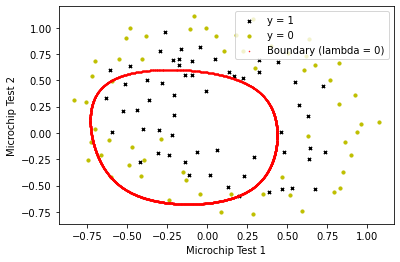

In [13]:
threshold = 1E-4
rlr_model = md.RegularizedLogisticRegression(x, y, lambda_value=100)
rlr_model.train(cgs)
x1_grid, x2_grid = show_decision_boundary(rlr_model.result.theta, degree, density, threshold)

plt.scatter(x1[index_1], x2[index_1], s=10, c='k', marker='x', label='y = 1')
plt.scatter(x1[index_0], x2[index_0], s=10, c='y', marker='o', label='y = 0')
plt.scatter(x1_grid, x2_grid, s=1, c='r', marker='.', label=f'Boundary (lambda = 0)')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc='upper right')
plt.show()

del rlr_model, x1_grid, x2_grid

In [14]:
# Finally, clean up Q2 memories
del data, x1, x2, y, x, index_1, index_0, degree, density, threshold
print('Successfully clean up Q2 memories')

Successfully clean up Q2 memories
